# Neal's Funnel Target Practice

In [1]:
] activate "../"

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using ForwardDiff
using LinearAlgebra
using Random
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
d = 21
@model function funnel()
    θ ~ Truncated(Normal(0, 3), -3, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

@model function true_funnel()
    θ ~ Truncated(Normal(0, 3), -3, 3)
    z ~ MvNormal(zeros(d-1), I)
    zz = z .* exp(θ/2)
    x ~ MvNormal(zz, I)
    
end

true_funnel (generic function with 2 methods)

In [4]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
funnel_model = funnel() | (;x)

Random.seed!(1)
(;x) = rand(true_funnel() | (θ=0,))
true_model = true_funnel() | (;x)

DynamicPPL.Model{typeof(true_funnel), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DynamicPPL.DefaultContext}}(true_funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [1.2142074831535152, 1.23371919965455, -0.8480146960461767, 0.1600994648479841, 1.9180385508479283, -3.401523464506408, -0.0957684186471088, 0.6734622629464286, -3.2749467689509633, -1.6760091758453226, 1.9567202902549736, 0.1136169088905351, 0.11117896909388916, -0.5373922347882832, -0.12436857036298687, -1.2901071061088532, 1.702584517514787, -0.44460133117954226, 1.0818722439221686, 1.2208011493237483],), DynamicPPL.DefaultContext()))

## MCHMC

In [5]:
target = TuringTarget(funnel_model; d=d, compute_MAP=false)
true_target = TuringTarget(true_model; d=d, compute_MAP=false);

In [6]:
spl = MCHMC(10_000, 0.01)
@time samples_mchmc = Sample(spl, target, 100_000; dialog=false);

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:03[ Info: eps: 1.8171440520737192
[ Info: L: 1.330251762086214
[ Info: nu: 0.8337061180423558
[ Info: sigma: [0.5152729255915817, 0.7274052491152833, 0.7277197354686511, 0.7403563852008592, 0.6803767628989182, 0.7512316171958546, 0.8868899597112992, 0.693462342177899, 0.7287280203708848, 0.8362230730542378, 0.7470016194510095, 0.7662158730798357, 0.7188613690104919, 0.7123643973492622, 0.7175404258097299, 0.7111803169235733, 0.7414431534682078, 0.7382913533157094, 0.7277413001062742, 0.7286531599292801, 0.7150864361048634]
[ Info: adaptive: false
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:02

 12.777836 seconds (51.14 M allocations: 21.126 GiB, 11.43% gc time, 56.52% compilation time: <1% of which was recompilation)


In [7]:
spl = MCHMC(10_000, 0.01; adaptive=true)
@time samples_mchmc_adaptive = Sample(spl, target, 100_000; dialog=false);

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:00[ Info: eps: 2.3610243145525294
[ Info: L: 1.7345649106421366
[ Info: nu: 0.9882733537022027
[ Info: sigma: [0.51887363799212, 0.7709969751280402, 0.7226732447091169, 0.7127181113155887, 0.7015442020635106, 0.7591246064300491, 0.8533621972015335, 0.7116321697903745, 0.7091430783315714, 0.8801576047285717, 0.7481210947471334, 0.7661055091423451, 0.7065833064029052, 0.7039434011812487, 0.6933960996292845, 0.6939270017887084, 0.7603728776490203, 0.7497205747481863, 0.7148400205184529, 0.736835789365416, 0.7496591293904742]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:02

  4.644671 seconds (34.49 M allocations: 19.967 GiB, 17.83% gc time)


In [8]:
#spl_ensemble = MCHMC(0.0, 0.0, 10; init_eps=0.3, varE_wanted=0.1, sigma=ones(d))
#@time samples_mchmc_ensemble = Sample(spl_ensemble, target, 10_000;
#                            burn_in=500, dialog=false);

In [9]:
theta_mchmc = [sample[1] for sample in samples_mchmc]
x10_mchmc = [sample[10+1] for sample in samples_mchmc]
E = [sample[end-1] for sample in samples_mchmc];
VarE = std(E)^2/d

0.006008809325296217

In [10]:
ESSs, rhat = Summarize(samples_mchmc)
ESS = mean(ESSs)
ESS/4.345784

NaN

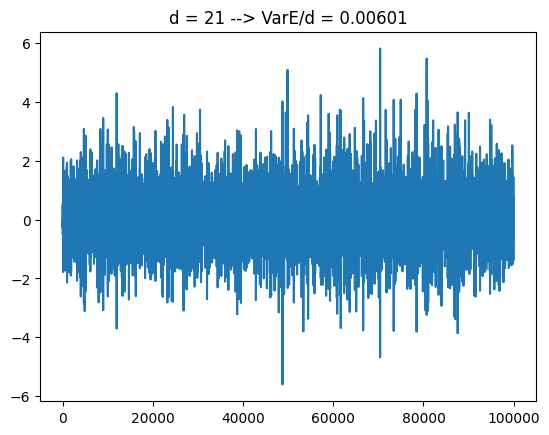

PyObject Text(0.5, 1.0, 'd = 21 --> VarE/d = 0.00601')

In [11]:
plt.plot(E, label="E/d")
plt.title(string("d = ", d, " --> VarE/d = ", round(VarE, digits=5)))

In [12]:
theta_mchmc_adaptive = [sample[1] for sample in samples_mchmc_adaptive]
x10_mchmc_adaptive = [sample[10+1] for sample in samples_mchmc_adaptive]
E_adaptive = [sample[end-1] for sample in samples_mchmc_adaptive]
VarE_adaptive = std(E_adaptive)^2/d

0.01353255284207117

In [13]:
ESSs_adaptive, rhat = Summarize(samples_mchmc_adaptive)
ESS_adaptive = mean(ESSs_adaptive)
ESS_adaptive/4.739692

4980.848139840785

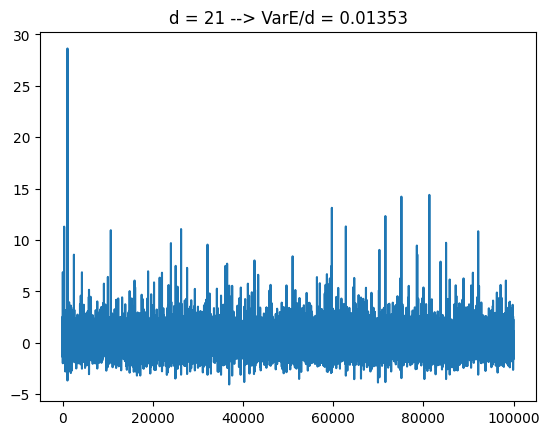

PyObject Text(0.5, 1.0, 'd = 21 --> VarE/d = 0.01353')

In [14]:
plt.plot(E_adaptive, label="E/d")
plt.title(string("d = ", d, " --> VarE/d = ", round(VarE_adaptive, digits=5)))

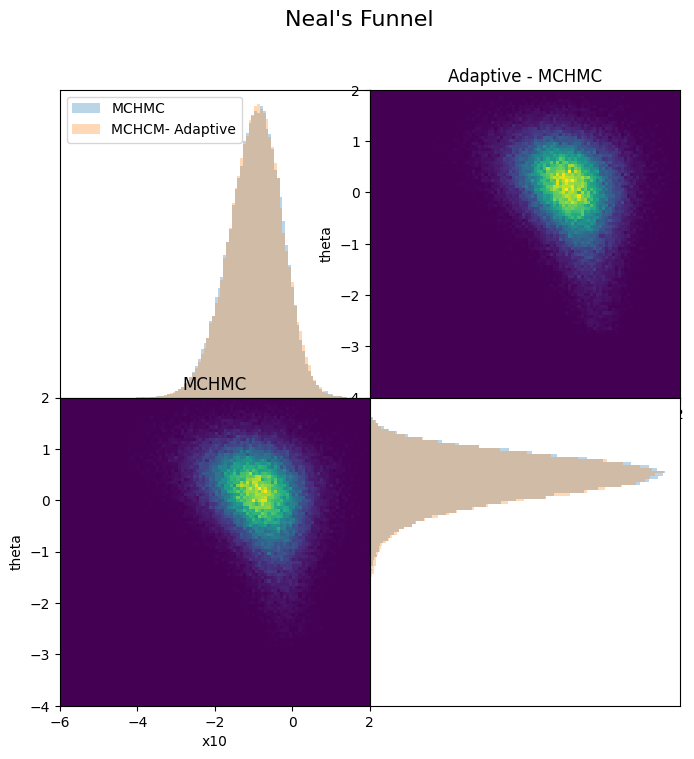

In [15]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2], alpha = 0.3, density=true, label="MCHMC")
axis[1,1].hist(x10_mchmc_adaptive, bins=100, range=[-6,2], alpha = 0.3, density=true, label="MCHCM- Adaptive")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3, density=true)
axis[2,2].hist(theta_mchmc_adaptive, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3, density=true)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(x10_mchmc_adaptive, theta_mchmc_adaptive, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("Adaptive - MCHMC")

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("MCHMC")
;

## NUTS

In [16]:
samples_hmc = sample(funnel_model, NUTS(10, 0.95), 50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 1.6
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:23


Chains MCMC chain (50000×33×1 Array{Float64, 3}):

Iterations        = 11:1:50010
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 26.93 seconds
Compute duration  = 26.93 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse      ess_bulk     ess_tail      rha ⋯
      Symbol   Float64   Float64   Float64       Float64      Float64   Float6 ⋯

           θ   -0.0007    0.6993    0.0083     9303.8183    6383.7027    1.000 ⋯
        z[1]    0.6152    0.7267    0.0031    55681.5646   34645.3219    1.000 ⋯
        z[2]    0.6216    0.7296    0.0031    55753.9522   35293.4105    1.000 ⋯
        z[3]   -0.4

In [17]:
truth_hmc = sample(true_model, NUTS(10, 0.95), 50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 1.6
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:26


Chains MCMC chain (50000×33×1 Array{Float64, 3}):

Iterations        = 11:1:50010
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 28.95 seconds
Compute duration  = 28.95 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse      ess_bulk     ess_tail      rha ⋯
      Symbol   Float64   Float64   Float64       Float64      Float64   Float6 ⋯

           θ   -0.0051    0.7214    0.0058    17061.6269   20063.4262    1.000 ⋯
        z[1]    0.5758    0.7089    0.0023    98677.3734   33720.7434    1.000 ⋯
        z[2]    0.5843    0.7062    0.0022   104114.0083   34076.1364    1.000 ⋯
        z[3]   -0.3

In [18]:
theta_hmc = [samples_hmc.value.data[i, 1, :][1] for i in axes(samples_hmc.value.data)[1]]
x10_hmc = [samples_hmc.value.data[i, 10+1, :][1] for i in axes(samples_hmc.value.data)[1]];


In [19]:
true_theta_hmc = [truth_hmc.value.data[i, 1, :][1] for i in axes(truth_hmc.value.data)[1]]
true_x10_hmc = [truth_hmc.value.data[i, 10+1, :][1] * exp(truth_hmc.value.data[i, 1, :][1]/2) for i in axes(truth_hmc.value.data)[1]];


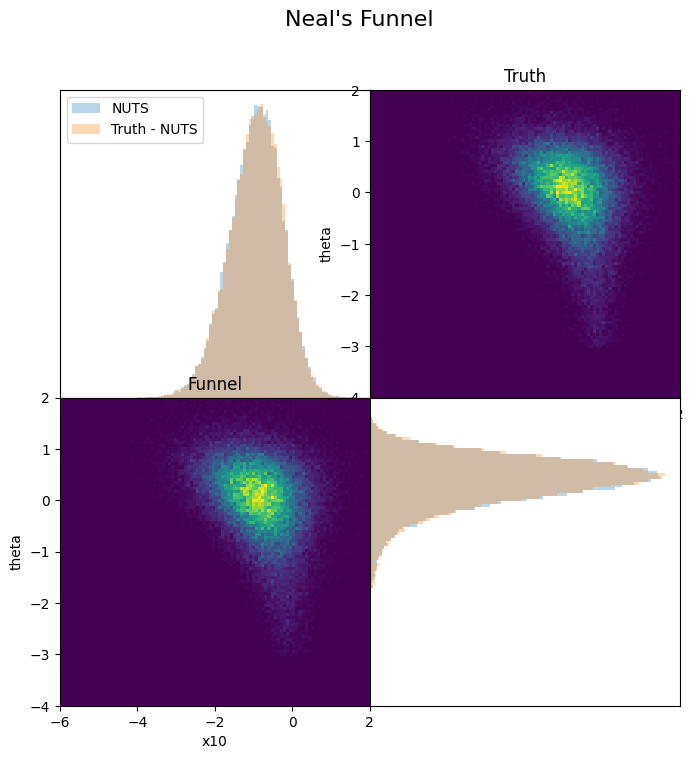

In [20]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_hmc, bins=100, range=[-6,2], alpha = 0.3, label="NUTS")
axis[1,1].hist(true_x10_hmc, bins=100, range=[-6,2], alpha = 0.3, label="Truth - NUTS")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_hmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(true_theta_hmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(true_x10_hmc, true_theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("Truth")

axis[2,1].hist2d(x10_hmc, theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("Funnel")
;

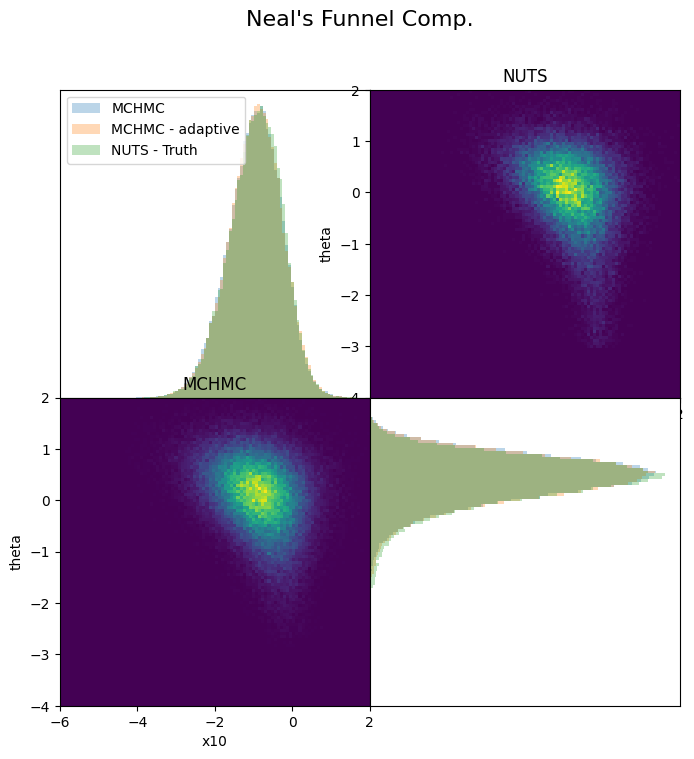

In [21]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel Comp.", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, density=true, range=[-6,2], alpha = 0.3, label="MCHMC")
axis[1,1].hist(x10_mchmc_adaptive, bins=100, density=true, range=[-6,2], alpha = 0.3, label="MCHMC - adaptive")
axis[1,1].hist(true_x10_hmc, bins=100, density=true, range=[-6,2], alpha = 0.3, label="NUTS - Truth")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, density=true, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(theta_mchmc_adaptive, bins=100, density=true, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(true_theta_hmc, bins=100, density=true, orientation="horizontal", range=[-6,2], alpha = 0.3)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(true_x10_hmc, true_theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("NUTS")

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("MCHMC")
;

In [22]:
println(median(true_theta_hmc), " --> ", mean(true_theta_hmc), " +/- ", std(true_theta_hmc))
println(median(true_x10_hmc), " --> ", mean(true_x10_hmc), " +/- ", std(true_x10_hmc))

0.08353049938204138 --> -0.00514114367417551 +/- 0.7214407233767024
-0.7985004925776178 --> -0.8390906279591538 +/- 0.7534769535321579
